In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Import data from B4PPI dataset

In [3]:
# Get the absolute path to the project root directory
project_root = os.path.abspath(os.path.dirname(os.getcwd()))

goldStandard_with_featuresSeq = pd.read_pickle(
    os.path.join(project_root, 'data', 'benchmarkingGS_v1-0_similarityMeasure_sequence_v3-1.pkl')
)

display(goldStandard_with_featuresSeq)

,uniprotID_A,uniprotID_B,isInteraction,trainTest,RNAseqHPA,tissueHPA,tissueCellHPA,subcellularLocationHPA,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot,Bgee,sequence_A,sequence_B
0,P28223,P41595,1,test2,0.160188,-0.449930,-0.060381,NaN,0.400892,0.404061,0.680414,0.0,0.790569,0.422078,MDILCEENTSLSSTTNSLMQLNDDTRLYSNDFNSGEANTSDAFNWT...,MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQI...
1,O00161,P56962,1,train,0.825131,0.851690,0.675880,0.000000,0.190693,0.200000,0.353553,0.0,0.000000,0.922975,MDNLSSEEIQQRAHQITDESLESTRRILGLAIESQDAGIKTITMLD...,MSEDEEKVKLRRLEPAIQKFIKIVIPTDLERLRKHQINIEKYQRCR...
2,P82979,Q01081,1,train,0.930790,0.954869,0.911887,0.000000,0.547723,0.365148,0.408248,0.0,0.000000,NaN,MATETVELHKLKLAELKQECLARGLETKGIKQDLIHRLQAYLEEHA...,MAEYLASIFGTEKDKVNCSFYFKIGACRHGDRCSRLHNKPTFSQTI...
3,O60678,Q14524,1,train,0.219384,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000,NaN,MCSLASGATGGRGAVENEEDLPELSDSGDEAAWEDEDDADLPHGKQ...,MANFLLPRGTSSFRRFTRESLAAIEKRMAEKQARGSTTLQESREGL...
4,P10275,Q15648,1,train,0.500558,-0.311704,-0.371061,0.000000,0.169811,0.375000,0.157895,0.0,0.000000,NaN,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...,MKAQGETEESEKLSKMSSLLERLHAKFNQNRPWSETIKLVRQVMEK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268494,O95678,Q8IYX3,0,test2,0.022646,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000,NaN,MSRQSSITFQSGSRRGFSTTSAITPAAGRSRFSSVSVARSAAGSGG...,MARCRHHSGYLADDEASHSMCSARVQLPKKPLVPEMRPACKPGRVP...
268495,O95835,Q8WUJ0,0,test2,0.854290,NaN,NaN,NaN,0.000000,0.447214,0.000000,0.0,0.000000,0.930655,MKRSEKPEGYRQMRPKTFPASNYTVSSRQMLQEIRESLRNLSKPSD...,MEDVKLEFPSLPQCKEDAEEWTYPMRREMQEILPGLFLGPYSSAMK...
268496,P60409,Q9NUB4,0,test2,0.894159,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000,NaN,MAASTMSVCSSDLSYGSRVCLPGSCDSCSDSWQVDDCPESCCEPPC...,MTRLCLPRPEAREDPIPVPPRGLGAGEGSGSPVRPPVSTWGPSWAQ...
268497,O43294,Q6ZRT6,0,test2,0.062636,NaN,NaN,0.288675,0.000000,0.000000,0.000000,0.0,0.000000,-0.606365,MEDLDALLSDLETTTSHMPRSGAPKERPAEPLTPPPSYGHQPQTGS...,MVSRPRSPSAFPAPWWGQQPGGPGPAKRLRLEEPAGPEPRAAPSLE...


## Data preprocessing

In [4]:
# Keep only the required columns
columns_to_keep = ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B']
data = goldStandard_with_featuresSeq[columns_to_keep]

# Creating train dataset (500 examples, 50% positive, 50% negative)
train_pos = data[(data['trainTest'] == 'train') & (data['isInteraction'] == 1)].sample(n=250, random_state=42)
train_neg = data[(data['trainTest'] == 'train') & (data['isInteraction'] == 0)].sample(n=250, random_state=42)
train_data = pd.concat([train_pos, train_neg])

# Creating cross-validation dataset (250 examples, 50% positive, 50% negative)
remaining_train_pos = data[(data['trainTest'] == 'train') & (data['isInteraction'] == 1)].drop(train_pos.index)
remaining_train_neg = data[(data['trainTest'] == 'train') & (data['isInteraction'] == 0)].drop(train_neg.index)
cv_pos = remaining_train_pos.sample(n=125, random_state=43)
cv_neg = remaining_train_neg.sample(n=125, random_state=43)
cv_data = pd.concat([cv_pos, cv_neg])
cv_data['trainTest'] = 'validation'  # Marking these as validation

# --- Test1: 250 examples, 50% positive, 50% negative ---
test1_pos_all = data[(data['trainTest'] == 'test1') & (data['isInteraction'] == 1)]
test1_neg_all = data[(data['trainTest'] == 'test1') & (data['isInteraction'] == 0)]

test1_n_pos = min(125, len(test1_pos_all))
test1_n_neg = min(125, len(test1_neg_all))

test1_pos = test1_pos_all.sample(n=test1_n_pos, random_state=44)
test1_neg = test1_neg_all.sample(n=test1_n_neg, random_state=44)
test1_data = pd.concat([test1_pos, test1_neg])

# --- Test2: 250 examples, ~5% positive, 95% negative ---
test2_pos_all = data[(data['trainTest'] == 'test2') & (data['isInteraction'] == 1)]
test2_neg_all = data[(data['trainTest'] == 'test2') & (data['isInteraction'] == 0)]

test2_n_pos = min(int(250 * 0.05), len(test2_pos_all))  # 5% of 250 = 12
test2_n_neg = min(250 - test2_n_pos, len(test2_neg_all))  # 238

test2_pos = test2_pos_all.sample(n=test2_n_pos, random_state=45)
test2_neg = test2_neg_all.sample(n=test2_n_neg, random_state=45)
test2_data = pd.concat([test2_pos, test2_neg])

# Shuffle the test sets to mix positive and negative examples
test1_data = test1_data.sample(frac=1, random_state=46).reset_index(drop=True)
test2_data = test2_data.sample(frac=1, random_state=47).reset_index(drop=True)

# Print dataset statistics
print(f"Train set: {train_data.shape}")
print(f"Train positive ratio: {train_data['isInteraction'].mean():.2f}")
print(f"\nValidation set: {cv_data.shape}")
print(f"Validation positive ratio: {cv_data['isInteraction'].mean():.2f}")
print(f"\nTest1 set: {test1_data.shape}")
print(f"Test1 positive ratio: {test1_data['isInteraction'].mean():.2f}")
print(f"\nTest2 set: {test2_data.shape}")
print(f"Test2 positive ratio: {test2_data['isInteraction'].mean():.2f}")

display(train_data)
display(cv_data)
display(test1_data)
display(test2_data)

# Save all datasets
os.makedirs('../data/small_set', exist_ok=True)
train_data.to_pickle('../data/small_set/train_data.pkl')
cv_data.to_pickle('../data/small_set/validation_data.pkl')
test1_data.to_pickle('../data/small_set/test1_data.pkl')
test2_data.to_pickle('../data/small_set/test2_data.pkl')

# Also save as CSV
train_data.to_csv('../data/small_set/train_data.csv', index=False)
cv_data.to_csv('../data/small_set/validation_data.csv', index=False)
test1_data.to_csv('../data/small_set/test1_data.csv', index=False)
test2_data.to_csv('../data/small_set/test2_data.csv', index=False)

print("\nAll datasets successfully saved to the 'data/small_set' directory")

Train set: (500, 6)
Train positive ratio: 0.50

Validation set: (250, 6)
Validation positive ratio: 0.50

Test1 set: (250, 6)
Test1 positive ratio: 0.50

Test2 set: (250, 6)
Test2 positive ratio: 0.05


,uniprotID_A,uniprotID_B,isInteraction,trainTest,sequence_A,sequence_B
35204,Q06250,Q15654,1,train,MQRRGQPLENHVALIHWQSAGIPASKVHNYCNMKKSRLGRSRAVRI...,MSGPTWLPPKQPEPARAPQGRAIPRGTPGPPPAHGAALQPHPRVNF...
64158,B2RXF5,Q96RF0,1,train,MEFPEHGGRLLGRLRQQRELGFLCDCTVLVGDARFPAHRAVLAACS...,MALRARALYDFRSENPGEISLREHEVLSLCSEQDIEGWLEGVNSRG...
66523,O95905,Q9H3M7,1,train,MEETMKLATMEDTVEYCLFLIPDESRDSDKHKEILQKYIERIITRF...,MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRI...
20138,P32856,Q5VZY2,1,train,MRDRLPDLTACRKNDDGDTVVVVEKDHFMDDFFHQVEEIRNSIDKI...,MRELAIEIGVRALLFGVFVFTEFLDPFQRVIQPEEIWLYKNPLVQS...
25743,Q8IWB6,Q9UBR4,1,train,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKG...,MLLETGLERDRARPGAAAVCTLGGTREIPLCAGCDQHILDRFILKA...
...,...,...,...,...,...,...
110746,Q8IVV8,Q8TCG1,0,train,MGSCSGRCALVVLCAFQLVAALERQVFDFLGYQWAPILANFVHIII...,MDSTACLKSLLLTVSQYKAVKSEANATQLLRHLEVISGQKLTRLFT...
125894,P49366,Q9NQX0,0,train,MEGSLEREAPAGALAAVLKHSSTLPPESTQVRGYDFNRGVNYRALL...,MLKPGDPGGSAFLKVDPAYLQHWQQLFPHGGAGPLKGSGAAGLLSA...
106702,O14893,Q9Y478,0,train,MRRAELAGLKTMAWVPAESAVEELMPRLLPVEPCDLTEGFDPSVPP...,MGNTSSERAALERHGGHKTPRRDSSGGTKDGDRPKILMDSPEDADL...
93745,P00533,Q68DC2,0,train,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,MGEGGLPPAFQLLLRACDQGDTETARRLLEPGAAEPAERGAEPEAG...


,uniprotID_A,uniprotID_B,isInteraction,trainTest,sequence_A,sequence_B
3468,Q15785,Q9BSI4,1,validation,MAPKFPDSVEELRAAGNESFRNGQYAEASALYGRALRVLQAQGSSD...,MATPLVAGPAALRFAAAASWQVVRGRCVEHFPRVLEFLRSLRAVAP...
28464,P43378,P51861,1,validation,MEPATAPRPDMAPELTPEEEQATKQFLEEINKWTVQYNVSPLSWNV...,MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...
46038,P54252,Q92995,1,validation,MESIFHEKQEGSLCAQHCLNNLLQGEYFSPVELSSIAHQLDEEERM...,MQRRGALFGMPGGSGGRKMAAGDIGELLVPHMPTIRVPRSGDRVYK...
24921,Q8N4B1,Q9NW61,1,validation,MKLNERSLAFYATCDAPVDNAGFLYKKGGRHAAYHRRWFVLRGNML...,MRYNEKELQALSRQPAEMAAELGMRGPKKGSVLKRRLVKLVVNFLF...
25417,Q5TA77,Q9BYQ3,1,validation,MSCQQNQQQCQPLPKCPSPKCPPKSSAQCLPPASSCCAPRPGCCGG...,MTHCCSPCCQPTCCRTTCWQPTTVTTCSSTPCCQPSCCVSSCCQPC...
...,...,...,...,...,...,...
111763,Q8IX05,Q8N5M9,0,validation,MLRAALPALLLPLLGLAAAAVADCPSSTWIQFQDSCYIFLQEAIKV...,MASRAGPRAAGTDGSDFQHRERVAMHYQMSVTLKYEIKKLIYVHLV...
101627,Q02930,Q9Y2K5,0,validation,MIYEESKMNLEQERPFVCSAPGCSQRFPTEDHLMIHRHKHEMTLKF...,MSNSNTTQETLEIMKESEKKLVEESVNKNKFISKTPSKEEIEKECE...
89503,P78362,Q9BVN2,0,validation,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPE...,MLSPQRALLCNLNHIHLQHVSLGLHLSRRPELQEGPLSTPPPPGDT...
85372,Q08379,Q3LI66,0,validation,MWPQPRLPPRPAMSEETRQSKLAAAKKKLREYQQRNSPGVPTGAKK...,MCGSYYGNYYGDHGYGCCGYEGLGYGYGSLRCGYSSCCGYGHGYGS...


,uniprotID_A,uniprotID_B,isInteraction,trainTest,sequence_A,sequence_B
0,A0AVK6,P42858,1,test1,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...
1,Q14781,Q15415,1,test1,MEELSSVGEQVFAAECILSKRLRKGKLEYLVKWRGWSSKHNSWEPE...,MVEADHPGKLFIGGLNRETNEKMLKAVFGKHGPISEVLLIKDRTSK...
2,A1L3X4,Q9HCC0,0,test1,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,MWAVLRLALRPCARASPAGPRAYHGDSVASLGTQPDLGSALYQENY...
3,O95810,Q9NPC7,0,test1,MGEDAAQAEKFQHPGSDMRQEKPSSPSPMPSSTPSPSLNLGNTEEA...,MQYSHHCEHLLERLNKQREAGFLCDCTIVIGEFQFKAHRNVLASFS...
4,O76024,Q8NBJ7,1,test1,MDSNTAPLGPSCPQPPPAPQPQARSRLNATASLEQERSERPRAPGP...,MARHGLPLLPLLSLLVGAWLKLGNGQATSMVQLQGGRFLMGTNSPD...
...,...,...,...,...,...,...
245,P78508,P82279,0,test1,MTSVAKVYYSQTTQTESRPLMGPGIRRRRVLTKDGRSNVRMEHIAD...,MALKNINYLLIFYLSFSLLIYIKNSFCNKNNTRCLSNSCQNNSTCK...
246,Q0VD86,Q13393,1,test1,MQVQDDGVNLIPFAKCSRVVSRSPPPRLPSQSLRPMPQRYGDVFWK...,MSLKNEPRVNTSALQKIAADMSNIIENLDTRELHFEGEEVDYDVSP...
247,O75934,Q96LX7,1,test1,MAGTGLVAGEVVVDALPYFDQGYEAPGVREAAAALVEEETRRYRPT...,MDSHSGEPALLPCGTCDMVFRSSALLATHTQRFCIGHPTQEMTFGA...
248,P42858,P61978,1,test1,MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPP...,METEQPEETFPNTETNGEFGKRPAEDMEEEQAFKRSRNTDEMVELR...


,uniprotID_A,uniprotID_B,isInteraction,trainTest,sequence_A,sequence_B
0,P07550,P32121,1,test2,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,MGEKPGTRVFKKSSPNCKLTVYLGKRDFVDHLDKVDPVDGVVLVDP...
1,O75083,Q9UBQ6,0,test2,MPYEIKKVFASLPQVERGVSKIIGGDPKGNNFLYTNGKCVILRNID...,MRCCHICKLPGRVMGIRVLRLSLVVILVLLLVAGALTALLPSVKED...
2,Q13133,Q68E01,0,test2,MSLWLGAPVPDIPPDSAVELWKPGAQDASSQAQGGSSCILREEARM...,MELQKGKGAAAAAAASGAAGGGGGGAGAGAPGGGRLLLSTSLDAKD...
3,Q5T230,Q8IXT5,0,test2,MLLRPRRPPPLAPPAPPSPASPDPEPRTPGDAPGTPPRRPASPSAL...,MAVVIRLLGLPFIAGPVDIRHFFTGLTIPDGGVHIIGGEIGEAFII...
4,P41440,Q9NYG5,0,test2,MVPSSPAVEKQVPVEPGPDPELRSWRHLVCYLCFYGFMAQIRPGES...,MKVKIKCWNGVATWLWVANDENCGICRMAFNGCCPDCKVPGDDCPL...
...,...,...,...,...,...,...
245,O14581,Q14204,0,test2,MEPENDTGISEFVLLGLSEEPELQPFLFGLFLSMYLVTVLGNLLII...,MSEPGGGGGEDGSAGLEVSAVQNVADVSVLQKHLRKLVPLLLEDGG...
246,P22607,Q86VI3,1,test2,MGAPACALALCVAVAIVAGASSESLGTEQRVVGRAAEVPGPEPGQQ...,MERRAAGPGWAAYERLTAEEMDEQRRQNVAYQYLCRLEEAKRWMEA...
247,P58397,Q86SG2,0,test2,MPCAQRSWLANLSVVAQLLNFGALCYGRQPQPGPVRFPDRRQEHFI...,MDFISIQQLVSGERVEGKVLGFGHGVPDPGAWPSDWRRGPQEAVAR...
248,P63211,Q9ULY5,0,test2,MPVINIEDLTEKDKLKMEVDQLKKEVTLERMLVSKCCEEVRDYVEE...,MNSSKSSETQCTERGCFSSQMFLWTVAGIPILFLSACFITRCVVTF...



All datasets successfully saved to the 'data/small_set' directory


## Encode protein sequences using ESM C

1. Loads your training and validation datasets
2. Initializes the ESM C 300M model (the most lightweight version)
3. Creates a function to get protein embeddings by:
    - Encoding each protein sequence
    - Mean-pooling the embeddings across sequence length to get a single vector per protein
4. Processes each dataset by:
    - Encoding both proteins in each pair
    - Adding the embeddings as new columns in the dataframe
5. Saves the updated datasets with embeddings

In [5]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
import torch
from tqdm import tqdm

/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Load the datasets
train_data = pd.read_pickle('../data/small_set/train_data.pkl')
cv_data = pd.read_pickle('../data/small_set/validation_data.pkl')

# Initialize ESM C model
print("Loading ESM C model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ESMC.from_pretrained("esmc_300m").to(device)
print(f"Model loaded on {device}")

def get_protein_embedding(sequence):
    """Get protein embedding for a given sequence"""
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    logits_output = model.logits(
        protein_tensor, 
        LogitsConfig(sequence=True, return_embeddings=True)
    )
    # Get the per-protein representation by mean-pooling across sequence length
    embedding = logits_output.embeddings.mean(dim=0)
    return embedding.cpu().numpy()

def process_dataset(df):
    """Process dataset to add embeddings for both protein sequences"""
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Process each protein pair
    embeddings_A = []
    embeddings_B = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Encoding proteins"):
        # Get embeddings for protein A and B
        embedding_A = get_protein_embedding(row['sequence_A'])
        embedding_B = get_protein_embedding(row['sequence_B'])
        
        embeddings_A.append(embedding_A)
        embeddings_B.append(embedding_B)
    
    # Store the embeddings as lists directly
    result_df['embedding_A'] = embeddings_A
    result_df['embedding_B'] = embeddings_B
    
    return result_df

# Process training and validation sets
print("Processing training set...")
train_data_with_embeddings = process_dataset(train_data)

print("Processing validation set...")
cv_data_with_embeddings = process_dataset(cv_data)

# Save the updated datasets
os.makedirs('../data/small_set/embeddings', exist_ok=True)
train_data_with_embeddings.to_pickle('../data/small_set/embeddings/train_data_with_embeddings.pkl')
cv_data_with_embeddings.to_pickle('../data/small_set/embeddings/validation_data_with_embeddings.pkl')

print("Embeddings have been generated and saved successfully.")

# Optional: Verify the shape of embeddings
print(f"Training set shape: {train_data_with_embeddings.shape}")
print(f"Embedding dimension: {len(train_data_with_embeddings['embedding_A'].iloc[0])}")

# Optionally, also encode test sets if needed
test1_data = pd.read_pickle('../data/small_set/test1_data.pkl')
test2_data = pd.read_pickle('../data/small_set/test2_data.pkl')

print("Processing test1 set...")
test1_data_with_embeddings = process_dataset(test1_data)

print("Processing test2 set...")
test2_data_with_embeddings = process_dataset(test2_data)

test1_data_with_embeddings.to_pickle('../data/small_set/embeddings/test1_data_with_embeddings.pkl')
test2_data_with_embeddings.to_pickle('../data/small_set/embeddings/test2_data_with_embeddings.pkl')

Loading ESM C model...
Model loaded on cuda
Processing training set...


Encoding proteins: 100%|██████████| 500/500 [00:29<00:00, 17.04it/s]


Processing validation set...


Encoding proteins: 100%|██████████| 250/250 [00:21<00:00, 11.55it/s]


Embeddings have been generated and saved successfully.
Training set shape: (500, 8)
Embedding dimension: 94
Processing test1 set...


Encoding proteins: 100%|██████████| 250/250 [00:15<00:00, 15.68it/s]


Processing test2 set...


Encoding proteins: 100%|██████████| 250/250 [00:15<00:00, 15.69it/s]


In [7]:
display(train_data_with_embeddings)
train_data_with_embeddings.to_csv('../data/small_set/embeddings/train_data_with_embeddings.csv')
cv_data_with_embeddings.to_csv('../data/small_set/embeddings/cv_data_with_embeddings.csv')
test1_data_with_embeddings.to_csv('../data/small_set/embeddings/test1_data_with_embeddings.csv')
test2_data_with_embeddings.to_csv('../data/small_set/embeddings/test2_data_with_embeddings.csv')

,uniprotID_A,uniprotID_B,isInteraction,trainTest,sequence_A,sequence_B,embedding_A,embedding_B
35204,Q06250,Q15654,1,train,MQRRGQPLENHVALIHWQSAGIPASKVHNYCNMKKSRLGRSRAVRI...,MSGPTWLPPKQPEPARAPQGRAIPRGTPGPPPAHGAALQPHPRVNF...,"[[0.0040463344, -0.0047846893, 0.0060664713, 0...","[[-0.004319614, -0.0013752867, -0.001106642, -..."
64158,B2RXF5,Q96RF0,1,train,MEFPEHGGRLLGRLRQQRELGFLCDCTVLVGDARFPAHRAVLAACS...,MALRARALYDFRSENPGEISLREHEVLSLCSEQDIEGWLEGVNSRG...,"[[0.00058840093, 0.0005644908, 0.0030562978, 5...","[[0.006623174, -0.0047159903, 0.0014346056, -0..."
66523,O95905,Q9H3M7,1,train,MEETMKLATMEDTVEYCLFLIPDESRDSDKHKEILQKYIERIITRF...,MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRI...,"[[0.0018549173, 0.0004384252, 0.0061595, -0.01...","[[0.005515831, -0.0030024706, -0.0043868315, -..."
20138,P32856,Q5VZY2,1,train,MRDRLPDLTACRKNDDGDTVVVVEKDHFMDDFFHQVEEIRNSIDKI...,MRELAIEIGVRALLFGVFVFTEFLDPFQRVIQPEEIWLYKNPLVQS...,"[[0.0024901088, -0.004126454, -7.399943e-06, -...","[[0.009619541, 0.0050388817, 0.004562311, -0.0..."
25743,Q8IWB6,Q9UBR4,1,train,MSRAVRLPVPCPVQLGTLRNDSLEAQLHEYVKQGNYVKVKKILKKG...,MLLETGLERDRARPGAAAVCTLGGTREIPLCAGCDQHILDRFILKA...,"[[0.0035845921, -0.0073618675, 0.004376486, -0...","[[-0.004016237, 0.0066845054, 0.0032082314, 0...."
...,...,...,...,...,...,...,...,...
110746,Q8IVV8,Q8TCG1,0,train,MGSCSGRCALVVLCAFQLVAALERQVFDFLGYQWAPILANFVHIII...,MDSTACLKSLLLTVSQYKAVKSEANATQLLRHLEVISGQKLTRLFT...,"[[-0.003561579, 0.006462363, -0.002433616, -0....","[[0.0065578357, -0.006022309, -0.0013284581, -..."
125894,P49366,Q9NQX0,0,train,MEGSLEREAPAGALAAVLKHSSTLPPESTQVRGYDFNRGVNYRALL...,MLKPGDPGGSAFLKVDPAYLQHWQQLFPHGGAGPLKGSGAAGLLSA...,"[[0.00013809986, 0.011786579, 0.00086629426, -...","[[-0.0004980295, -0.00097591383, 0.0021197211,..."
106702,O14893,Q9Y478,0,train,MRRAELAGLKTMAWVPAESAVEELMPRLLPVEPCDLTEGFDPSVPP...,MGNTSSERAALERHGGHKTPRRDSSGGTKDGDRPKILMDSPEDADL...,"[[0.0009694404, -0.0006985947, 0.0014572814, -...","[[0.0023083356, 0.00015099914, 0.0020091757, -..."
93745,P00533,Q68DC2,0,train,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,MGEGGLPPAFQLLLRACDQGDTETARRLLEPGAAEPAERGAEPEAG...,"[[0.0020217204, 0.0045453333, 0.0038571456, -0...","[[0.0019366826, 0.001886785, 0.00038529382, -0..."


Type of embedding_A: <class 'numpy.ndarray'>
Shape of embedding_A: (94, 960)
  - First dimension (94): Number of residues/amino acids in the protein
  - Second dimension (960): Per-residue embedding dimension from ESM C model

Type of embedding_B: <class 'numpy.ndarray'>
Shape of embedding_B: (478, 960)

After averaging across residues (protein-level embedding):
  - embedding_A averaged shape: (960,)
  - embedding_B averaged shape: (960,)


Text(0.5, 1.0, 'First 20 dimensions of embedding_A\n(protein-level embedding)')

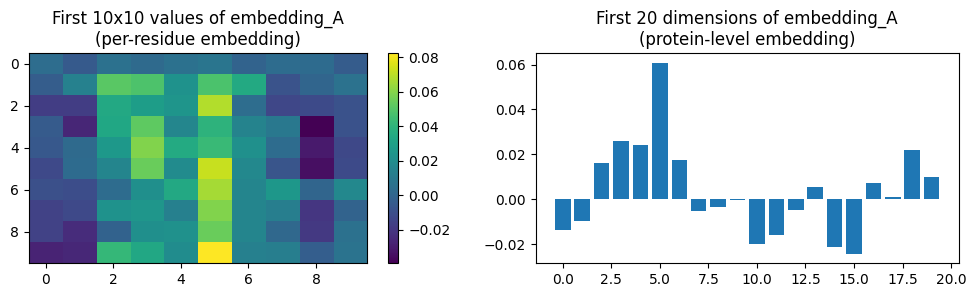

In [8]:
train_data_with_embeddings = pd.read_pickle('../data/small_set/embeddings/train_data_with_embeddings.pkl')

# Get an example embedding from embedding columns
emb_A = train_data_with_embeddings['embedding_A'].iloc[0]
emb_B = train_data_with_embeddings['embedding_B'].iloc[0]

# Print the type and shape information
print(f"Type of embedding_A: {type(emb_A)}")
print(f"Shape of embedding_A: {emb_A.shape}")
print(f"  - First dimension ({emb_A.shape[0]}): Number of residues/amino acids in the protein")
print(f"  - Second dimension ({emb_A.shape[1]}): Per-residue embedding dimension from ESM C model")

print(f"\nType of embedding_B: {type(emb_B)}")
print(f"Shape of embedding_B: {emb_B.shape}")

# Calculate protein-level embeddings by averaging across residues
avg_emb_A = np.mean(emb_A, axis=0)
print(f"\nAfter averaging across residues (protein-level embedding):")
print(f"  - embedding_A averaged shape: {avg_emb_A.shape}")

# If embedding_B is also a 2D array (per-residue embeddings), average it too
if len(emb_B.shape) > 1:
    avg_emb_B = np.mean(emb_B, axis=0)
    print(f"  - embedding_B averaged shape: {avg_emb_B.shape}")

# Visualize a small section of the embeddings
plt.figure(figsize=(12, 6))

# Plot a heatmap of a small section of the per-residue embedding
plt.subplot(2, 2, 1)
plt.imshow(emb_A[:10, :10], aspect='auto')
plt.colorbar()
plt.title('First 10x10 values of embedding_A\n(per-residue embedding)')

# Plot a few dimensions of the protein-level embedding
plt.subplot(2, 2, 2)
plt.bar(range(20), avg_emb_A[:20])
plt.title('First 20 dimensions of embedding_A\n(protein-level embedding)')

### ESM C Embedding Information:
1. ESM C produces embeddings that capture the biological properties of proteins
2. The per-residue embeddings (shape 94×960) provide a representation for each amino acid
   in the context of the entire protein sequence
3. Each amino acid position gets its own 960-dimensional vector capturing:
   - Local structural context
   - Chemical properties
   - Evolutionary conservation
   - Functional significance
4. When averaged, they become a protein-level embedding (shape 960) that represents
   the entire protein as a single vector
5. Individual dimensions don't have specific interpretable meanings, but collectively
   they form a distributed representation of protein properties
6. According to the ESM readme, ESM C is specifically designed for representation
   learning and is more efficient than previous models like ESM-2
7. These embeddings can be used for various tasks like protein function prediction,
   structure prediction, protein comparison, and protein engineering

## Simple experiment with L2 Distance and cosine similarity

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import os

# Load datasets with embeddings
print("Loading datasets...")

# Get the absolute path to the project root directory
project_root = os.path.abspath(os.path.dirname(os.getcwd()))

# Correctly use os.path.join for file paths
train_data = pd.read_pickle(os.path.join(project_root, 'data/small_set/embeddings/train_data_with_embeddings.pkl'))
val_data = pd.read_pickle(os.path.join(project_root, 'data/small_set/embeddings/validation_data_with_embeddings.pkl'))
test1_data = pd.read_pickle(os.path.join(project_root, 'data/small_set/embeddings/test1_data_with_embeddings.pkl'))
test2_data = pd.read_pickle(os.path.join(project_root, 'data/small_set/embeddings/test2_data_with_embeddings.pkl'))

# Display the shapes of loaded datasets
print("\nDataset shapes:")
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test1 set: {test1_data.shape}")
print(f"Test2 set: {test2_data.shape}")

Loading datasets...

Dataset shapes:
Training set: (500, 8)
Validation set: (250, 8)
Test1 set: (250, 8)
Test2 set: (250, 8)


Processing Train dataset...
Train AUC: 0.5372, AP: 0.5378
Processing Validation dataset...
Validation AUC: 0.5578, AP: 0.5629
Processing Test1 dataset...
Test1 AUC: 0.5295, AP: 0.5133
Processing Test2 dataset...
Test2 AUC: 0.5613, AP: 0.0568
Train Accuracy with threshold 0.3509: 0.5060
Validation Accuracy with threshold 0.3509: 0.5080
Test1 Accuracy with threshold 0.3509: 0.5040
Test2 Accuracy with threshold 0.3509: 0.0640


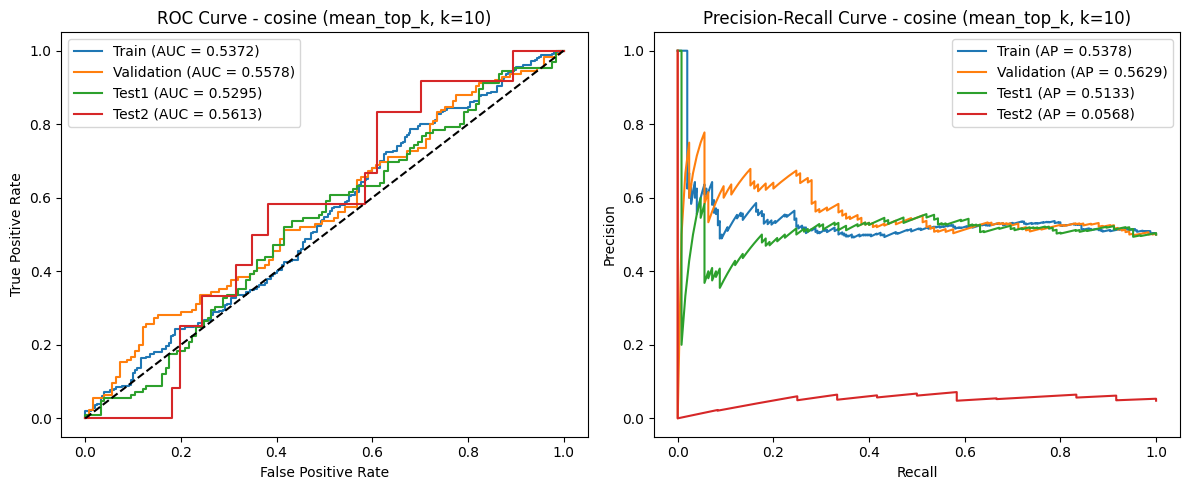

Processing Train dataset...
Train AUC: 0.5425, AP: 0.5395
Processing Validation dataset...
Validation AUC: 0.5475, AP: 0.5615
Processing Test1 dataset...
Test1 AUC: 0.5510, AP: 0.5373
Processing Test2 dataset...
Test2 AUC: 0.5676, AP: 0.0576
Train Accuracy with threshold -1.6552: 0.5040
Validation Accuracy with threshold -1.6552: 0.4960
Test1 Accuracy with threshold -1.6552: 0.5000
Test2 Accuracy with threshold -1.6552: 0.0480


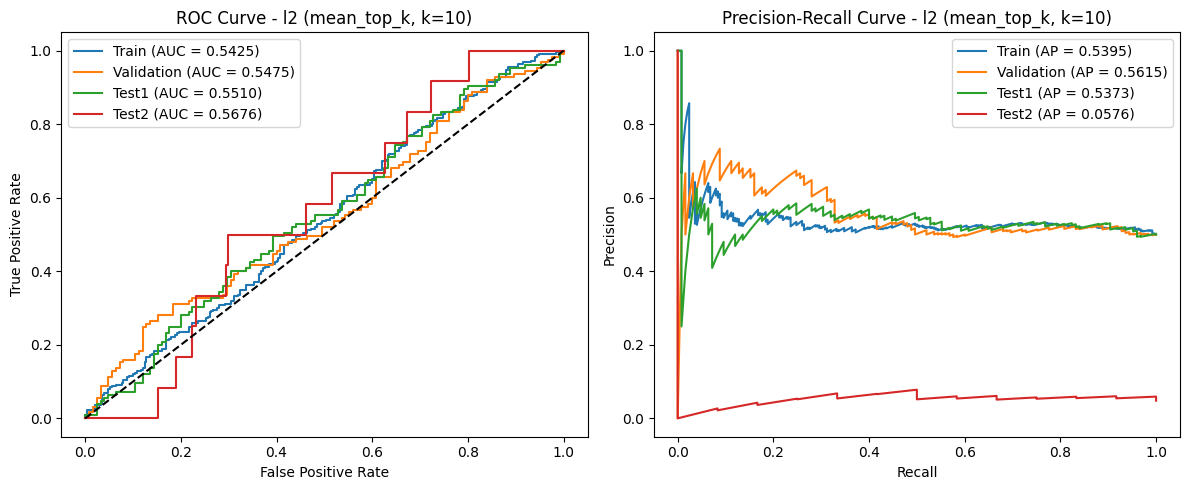


Evaluating with k=5
Processing Train dataset...
Train AUC: 0.5399, AP: 0.5403
Processing Validation dataset...
Validation AUC: 0.5595, AP: 0.5657
Processing Test1 dataset...
Test1 AUC: 0.5330, AP: 0.5216
Processing Test2 dataset...
Test2 AUC: 0.5630, AP: 0.0572
Train Accuracy with threshold 0.3683: 0.5080
Validation Accuracy with threshold 0.3683: 0.5080
Test1 Accuracy with threshold 0.3683: 0.5040
Test2 Accuracy with threshold 0.3683: 0.0600
Processing Train dataset...
Train AUC: 0.5461, AP: 0.5425
Processing Validation dataset...
Validation AUC: 0.5496, AP: 0.5640
Processing Test1 dataset...
Test1 AUC: 0.5547, AP: 0.5454
Processing Test2 dataset...
Test2 AUC: 0.5648, AP: 0.0573
Train Accuracy with threshold -1.5740: 0.5040
Validation Accuracy with threshold -1.5740: 0.5000
Test1 Accuracy with threshold -1.5740: 0.5000
Test2 Accuracy with threshold -1.5740: 0.0480

Evaluating with k=10
Processing Train dataset...
Train AUC: 0.5372, AP: 0.5378
Processing Validation dataset...
Validati

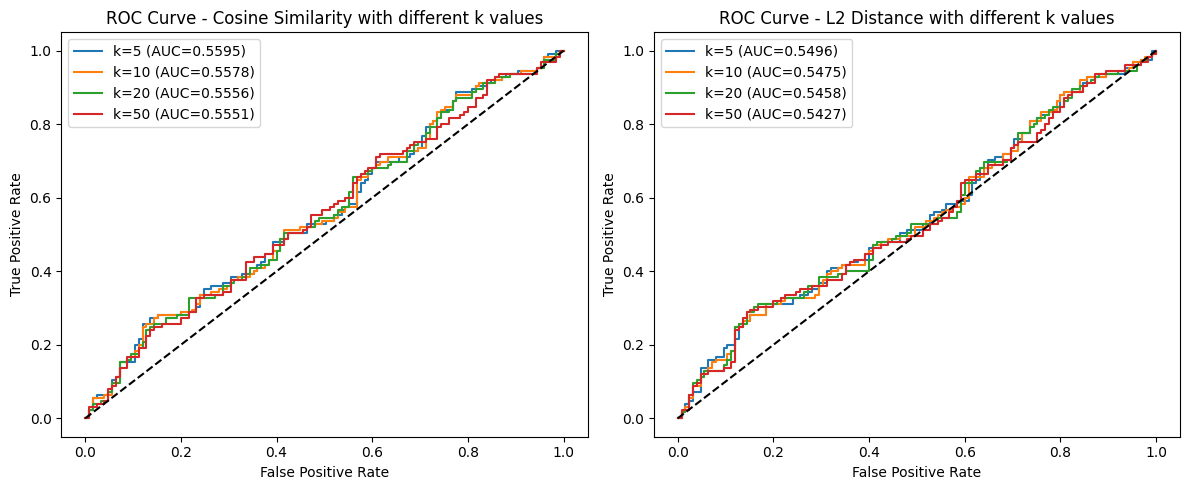

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Function to compute similarity scores between two proteins using residue-wise comparisons
def compute_protein_similarity(emb_A, emb_B, method='mean_top_k', k=10, similarity_type='cosine'):
    """
    Compute similarity between two proteins based on per-residue embeddings
    
    Parameters:
    - emb_A, emb_B: Per-residue embeddings of shape (L_A, d) and (L_B, d)
    - method: How to aggregate the similarity matrix ('mean_top_k', 'max', 'mean')
    - k: Number of top matches to consider when using 'mean_top_k'
    - similarity_type: 'cosine' or 'l2'
    
    Returns:
    - similarity_score: A single score representing protein similarity
    """
    if similarity_type == 'cosine':
        # Higher value means more similar
        similarity_matrix = cosine_similarity(emb_A, emb_B)  # shape: (L_A, L_B)
        
        if method == 'max':
            # Take max similarity across all residue pairs
            return np.max(similarity_matrix)
        elif method == 'mean':
            # Take average similarity across all residue pairs
            return np.mean(similarity_matrix)
        elif method == 'mean_top_k':
            # For each residue in A, find top k matching residues in B
            top_k_A = np.mean(np.sort(similarity_matrix, axis=1)[:, -k:])
            # For each residue in B, find top k matching residues in A
            top_k_B = np.mean(np.sort(similarity_matrix.T, axis=1)[:, -k:])
            # Average of both directions
            return (top_k_A + top_k_B) / 2
            
    elif similarity_type == 'l2':
        # Lower value means more similar
        distance_matrix = pairwise_distances(emb_A, emb_B, metric='euclidean')  # shape: (L_A, L_B)
        
        if method == 'min':
            # Take min distance across all residue pairs
            return np.min(distance_matrix)
        elif method == 'mean':
            # Take average distance across all residue pairs
            return np.mean(distance_matrix)
        elif method == 'mean_bottom_k':
            # For each residue in A, find k closest residues in B
            bottom_k_A = np.mean(np.sort(distance_matrix, axis=1)[:, :k])
            # For each residue in B, find k closest residues in A
            bottom_k_B = np.mean(np.sort(distance_matrix.T, axis=1)[:, :k])
            # Average of both directions
            return (bottom_k_A + bottom_k_B) / 2
    
    return None

# Compute similarities for datasets and evaluate performance
def evaluate_method(train_data, val_data, test1_data, test2_data, method='mean_top_k', k=10, 
                    similarity_type='cosine', plot=True):
    """
    Compute similarities for all pairs in datasets and evaluate performance
    """
    datasets = {
        'Train': train_data,
        'Validation': val_data,
        'Test1': test1_data,
        'Test2': test2_data
    }
    
    results = {}
    
    for name, data in datasets.items():
        print(f"Processing {name} dataset...")
        similarities = []
        
        for i, row in data.iterrows():
            emb_A = row['embedding_A']
            emb_B = row['embedding_B']
            
            if similarity_type == 'cosine':
                sim = compute_protein_similarity(emb_A, emb_B, method=method, k=k, 
                                                similarity_type='cosine')
                similarities.append(sim)
            else:  # l2
                dist = compute_protein_similarity(emb_A, emb_B, 
                                                method='mean_bottom_k' if method == 'mean_top_k' else method,
                                                k=k, similarity_type='l2')
                similarities.append(dist)
        
        # Add similarities to the dataset
        data[f'{similarity_type}_similarity'] = similarities
        
        # Calculate metrics for classification
        labels = data['isInteraction'].values  # Changed from 'label' to 'isInteraction'
        scores = data[f'{similarity_type}_similarity'].values
        
        if similarity_type == 'l2':
            # Lower L2 means more similar, so flip the sign
            scores = -scores
            
        fpr, tpr, thresholds = roc_curve(labels, scores)
        auc_score = auc(fpr, tpr)
        
        precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
        ap_score = average_precision_score(labels, scores)
        
        # Find best threshold on validation set
        if name == 'Validation':
            # Find threshold that maximizes F1 score
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            best_idx = np.argmax(f1_scores)
            best_threshold = pr_thresholds[best_idx] if best_idx < len(pr_thresholds) else 0
            
        results[name] = {
            'AUC': auc_score,
            'AP': ap_score,
            'FPR': fpr,
            'TPR': tpr,
            'Precision': precision,
            'Recall': recall
        }
        
        print(f"{name} AUC: {auc_score:.4f}, AP: {ap_score:.4f}")
    
    # Evaluate with best threshold
    for name, data in datasets.items():
        scores = data[f'{similarity_type}_similarity'].values
        if similarity_type == 'l2':
            scores = -scores
        
        predictions = (scores > best_threshold).astype(int)
        accuracy = np.mean(predictions == data['isInteraction'].values)  # Changed from 'label' to 'isInteraction'
        print(f"{name} Accuracy with threshold {best_threshold:.4f}: {accuracy:.4f}")
    
    if plot:
        # Plot ROC curves
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        for name, metrics in results.items():
            plt.plot(metrics['FPR'], metrics['TPR'], label=f"{name} (AUC = {metrics['AUC']:.4f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {similarity_type} ({method}, k={k})')
        plt.legend()
        
        # Plot Precision-Recall curves
        plt.subplot(1, 2, 2)
        for name, metrics in results.items():
            plt.plot(metrics['Recall'], metrics['Precision'], label=f"{name} (AP = {metrics['AP']:.4f})")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {similarity_type} ({method}, k={k})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    return best_threshold, results

# Example usage:
# 1. For Cosine Similarity with top-k matching
best_threshold_cos, results_cos = evaluate_method(
    train_data, val_data, test1_data, test2_data,
    method='mean_top_k', k=10, similarity_type='cosine'
)

# 2. For L2 Distance with bottom-k matching
best_threshold_l2, results_l2 = evaluate_method(
    train_data, val_data, test1_data, test2_data,
    method='mean_top_k', k=10, similarity_type='l2'
)

# 3. Compare with different k values
k_values = [5, 10, 20, 50]
cosine_results = {}
l2_results = {}

for k in k_values:
    print(f"\nEvaluating with k={k}")
    _, cosine_results[k] = evaluate_method(
        train_data, val_data, test1_data, test2_data,
        method='mean_top_k', k=k, similarity_type='cosine', plot=False
    )
    
    _, l2_results[k] = evaluate_method(
        train_data, val_data, test1_data, test2_data,
        method='mean_top_k', k=k, similarity_type='l2', plot=False
    )

# Plot comparison of different k values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for k in k_values:
    plt.plot(cosine_results[k]['Validation']['FPR'], 
             cosine_results[k]['Validation']['TPR'], 
             label=f"k={k} (AUC={cosine_results[k]['Validation']['AUC']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cosine Similarity with different k values')
plt.legend()

plt.subplot(1, 2, 2)
for k in k_values:
    plt.plot(l2_results[k]['Validation']['FPR'], 
             l2_results[k]['Validation']['TPR'], 
             label=f"k={k} (AUC={l2_results[k]['Validation']['AUC']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - L2 Distance with different k values')
plt.legend()

plt.tight_layout()
plt.show()